# Описание проекта

Необходимо оценить влияние семейного положения и наличия и количества детей клиента на погашение кредита в срок на основе статистики о платёжеспособности клиентов.

# Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import random
from nltk.stem import SnowballStemmer
from collections import Counter
from pymystem3 import Mystem

In [2]:
data = pd.read_csv('data.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В датасете 21525 строк, выборка достаточна для проведения анализа.

## Пропуски

Пропуски есть в колонках:
* days_employed и
* total_income

Пропуски могут быть связано с тем, что не все клиенты готовы раскрывать информацию о стаже и доходах.

Количество пропусков одинаковое, составляет около 

In [3]:
print(round(data['days_employed'].isna().mean() * 100, 2), "% от выборки")

10.1 % от выборки


## Названия колонок
dob_years (возраст клиента) - неявно названный столбец. Его следует переименовать в **client_age**:

In [4]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [5]:
data.set_axis(['children', 'days_employed', 'client_age', 'education', 'education_id', 'family_status', 'family_status_id', 'gender', 'income_type', 'debt', 'total_income', 'purpose'], axis = 1, inplace = True)

data.columns

Index(['children', 'days_employed', 'client_age', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

## Тип данных

Колонки имеют три типа данных:

* целые числа,
* строки,
* вещественные числа. 

Возможно, есть необходимость смены типа данных в колонках: days_employed - количество дней должно быть целочисленным, а не вещественным.

### Некорректные значения

Рассмотрим начало и конец датафрейма:

In [6]:
print(data.head(10))
print('')
print(data.tail(10))

   children  days_employed  client_age education  education_id  \
0         1   -8437.673028          42    высшее             0   
1         1   -4024.803754          36   среднее             1   
2         0   -5623.422610          33   Среднее             1   
3         3   -4124.747207          32   среднее             1   
4         0  340266.072047          53   среднее             1   
5         0    -926.185831          27    высшее             0   
6         0   -2879.202052          43    высшее             0   
7         0    -152.779569          50   СРЕДНЕЕ             1   
8         2   -6929.865299          35    ВЫСШЕЕ             0   
9         0   -2188.756445          41   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем           

выявленные некорректные значения:

* days_employed - наличие отрицательных значений, наличие сверхвысоких значений (ошибка разряда)
* education - различное написание одних и тех же категорий - строчные и прописные буквы
* purpose - различная формулировка целей - сделка с автомобилем, покупка автомобиля, покупка своего автомобиля, покупка жилья, операции с жильём, образование, дополнительное образование и пр.

## Необходимые колонки

Для ответа на изначально поставленные вопросы нужны следующие колонки:
* children,
* family_status и
* debt
    
Для ответа на дополнительные вопросы нужны ещё следующие колонки:
* total_income и
* purpose


In [7]:
print(data['children'].value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


в колонке children возможно некорректное значение 20, которое м.б. на самом деле 2, а также точно некорректное значение -1, которое, скорее всего, должно быть 1

In [8]:
print(data['family_status'].value_counts())

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64


в колонке family_status пропусков и дубликатов нет, есть только категория, начинающаяся с заглавной буквы, что можно скорректировать:

In [9]:
data['family_status'] = data['family_status'].str.lower()
print(data['family_status'].value_counts())

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64


In [10]:
print(data['debt'].value_counts())

0    19784
1     1741
Name: debt, dtype: int64


количество должников невелико и составляет

In [11]:
print(round(data[data['debt'] == 1]['debt'].count() / len(data) * 100, 1), "% от выборки")

8.1 % от выборки


In [12]:
data.describe()

,children,days_employed,client_age,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Вывод**

Для ответа на основные вопросы необходимо:   
* обработка дубликатов колонки children
* категоризация данных children, поскольку в одной из версий вопроса нет связи с количеством детей и достаточно иметь переменную типа boolean, отражающую наличие детей. В этом случае выявленные некорректные значения 20 и -1 будут отнесены в одну группу. Их количество составляет:

In [13]:
print(round(data[data['children'] == 20]['children'].count() / 21515 * 100, 2), "%")
print(round(data[data['children'] == -1]['children'].count() / 21515 * 100, 2), '%')

0.35 %
0.22 %


что не является критичным в случае неверного предположения о том, что 20 д.б. 2, а -1 д.б. 1.

Для ответа на дополнительные вопросы необходимо:
* заполнение пропусков total_income и
* лемматизация purpose.

Не нужно для ответа на вопросы, но сделано в рамках обучения:
* заполнение пропусков days_employed,
* смены типа данных days_employed на целочисленный,
* замена отрицательных значений days_employed на положительные,
* приведение сверхвысоких значений days_employed к реальным,
* обработка дубликатов education - приедение к единому написанию значений строчными буквами

# Предобработка данных

## Обработка пропусков

Строки с пропущенными значениями total_income и days_employed составляют около 10%. Потеря 10% строк  может оказать влияние на выводы, сделанные по другим колонкам. Следовательно, предпочтительнее заполнить пропуски.

Значения в колонках total_income и days_employed имеют тип вещественных чисел и отражают общий доход клиента и трудовой стаж в днях. Данные являются количественными и пропуски могут быть заменены характерными значениями в выборке.

### Обработка пропусков колонки total_income.

Исследуем выборку вычислив минимальное, максимальное, среднее и медианное значения: 

In [14]:
print(f"Количество строк до обработки пропусков {data['total_income'].count()}\n")
print(f"минимальное значение {round(data['total_income'].min())}\
\nмаксимальное значение {round(data['total_income'].max())}\
\nсреднее значение {round((data['total_income'].mean()))}\
\nмедианное значение {round((data['total_income'].median()))}")

Количество строк до обработки пропусков 19351

минимальное значение 20667
максимальное значение 2265604
среднее значение 167422
медианное значение 145018


In [15]:
data.pivot_table(index = 'income_type', values = 'total_income', aggfunc = 'median').sort_values('total_income')

,total_income
income_type,
в декрете,53829.130729
студент,98201.625314
пенсионер,118514.486412
безработный,131339.751676
сотрудник,142594.396847
госслужащий,150447.935283
компаньон,172357.950966
предприниматель,499163.144947


In [16]:
print(data[data['income_type'] == 'в декрете']['total_income'].median())

53829.13072905995


In [17]:
income_types = data['income_type'].unique()

def income_fillna(row):
    if pd.isna(row['total_income']):
        for i in income_types:
            if row['income_type'] == i:
                row['total_income'] = data[data['income_type'] == i]['total_income'].median() #присвоение медианы исходя из группы занятости
                return row
    else:
        return row
    
data = data.apply(income_fillna, axis = 1)

print(f"\nКоличество строк после обработки пропусков {data['total_income'].count()}")


Количество строк после обработки пропусков 21525


### Обработка некорректных значений колонки days_employed.

Количество проработанных дней логичнее всего анализировать вместе с возрастом клиента:

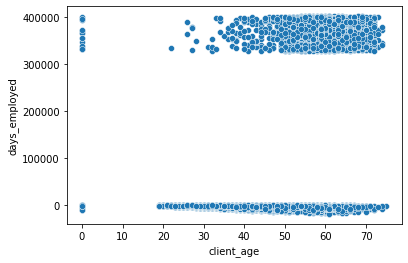

In [18]:
age_vs_days = data[['days_employed', 'client_age']] #для анализа выделим только нужные данные в отдельный датафрейм

plot = sns.scatterplot(data = age_vs_days, x = 'client_age', y = 'days_employed') #зависимости двух количественных переменных удобно смотреть на графике

на графике выделяются две области - с нормальными значениями и сверхвысокими. Также обнаруживаются нулевые значения в колонке client_age. Разделим облака точек с нормальными некорректными значениями days_employed

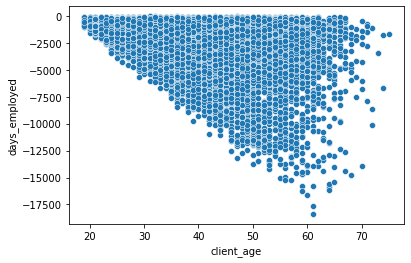

In [19]:
age_vs_days_filtered = age_vs_days[(age_vs_days['days_employed'] < 100000) & (age_vs_days['client_age'] > 10)]
age_vs_days_incorrect = age_vs_days[age_vs_days['days_employed'] > 100000]

plot = sns.scatterplot(data = age_vs_days_filtered, x = 'client_age', y = 'days_employed')

Отрицательные значения следует обратить в положительные:

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


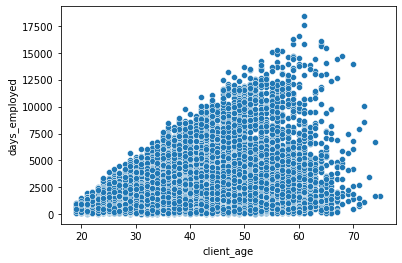

In [20]:
age_vs_days_filtered.loc[:,'days_employed'] = age_vs_days_filtered.loc[:,'days_employed'] * -1
plot_one = sns.scatterplot(data = age_vs_days_filtered, x = 'client_age', y = 'days_employed')

В остальном наблюдаем относительно адекватные значения - при трудовом стаже в 40 лет и пятидневной рабочей неделе человек работает 40 х 365 х 5/7 = 10428.57 дней.

Рассмотрим выборку значений, отобранных как некорректные и сравним значения с корректной выборкой:

20444    328728.720605
9328     328734.923996
17782    328771.341387
14783    328795.726728
7229     328827.345667
             ...      
7794     401663.850046
2156     401674.466633
7664     401675.093434
10006    401715.811749
6954     401755.400475
Name: days_employed, Length: 3445, dtype: float64

17437       24.141633
8336        24.240695
6157        30.195337
9683        33.520665
2127        34.701045
             ...     
16825    16119.687737
17838    16264.699501
7329     16593.472817
4299     17615.563266
16335    18388.949901
Name: days_employed, Length: 15832, dtype: float64


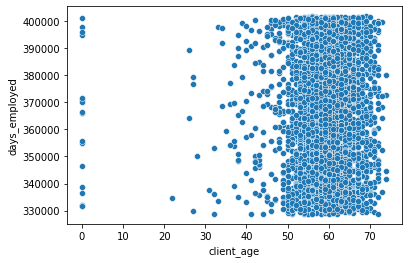

In [21]:
print(age_vs_days_incorrect['days_employed'].sort_values())
print()
print(age_vs_days_filtered['days_employed'].sort_values())

plot = sns.scatterplot(data = age_vs_days_incorrect, x = 'client_age', y = 'days_employed')

Из представленного следует, что некорректные значения days_employed изменяются от 328728 до 401755, тогда как корректные значения не превышают 18388. Из графика видно, что большинство некорректных значений сгруппировано в возрастной категории клиентов от 50 до 70 лет. Предположим что некорректные значения были введены из-за ошибки разряда и всё должно быть разделено на 100. Посмотрим где в таком случае на графике будут исправленные значения:

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


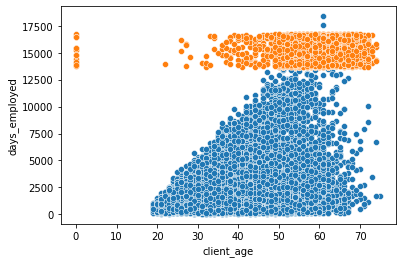

In [22]:
age_vs_days_incorrect.loc[:,'days_employed'] = age_vs_days_incorrect.loc[:,'days_employed'] / 24

plot_one = sns.scatterplot(data = age_vs_days_filtered, x = 'client_age', y = 'days_employed')
plot_two = sns.scatterplot(data = age_vs_days_incorrect, x = 'client_age', y = 'days_employed')

Исправленные значения ложатся в облако точек предполагаемых верных значений, следовательно, допускаем что обработка неверных значений колонки days_employed выполнена верно.

### Обработка пропусков колонки days_employed

Рассмотрим какие значения возраста (client_age) у пропущенных значений days_employed:

In [23]:
nan_days = age_vs_days[age_vs_days['days_employed'].isna() == True]

print(nan_days.agg({'client_age': ['min','mean','median','max']}))

        client_age
min       0.000000
mean     43.632015
median   43.000000
max      73.000000


Разброс возрастов (client_age) для значений NaN в колонке days_employed достаточно велик; медианное и среднее значения близки. Пустые значения можно заполнить либо константой, либо случайными значениями с зависимостью от возраста:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   client_age        21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


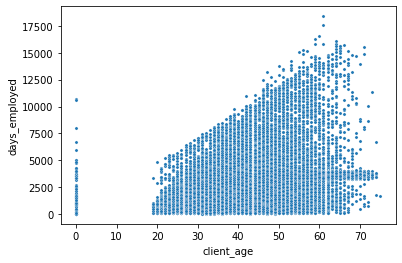

In [24]:
#Способ 1: функция заполняет пустые значения days_employed константой
def days_employed_corr(row):
    if row < 0:
        row = row * -1
        return row
    elif row > 100000:
        row = row / 100
        return row
    elif pd.isna(row):
        row = 20000
        return row

#выявлен недостаток - на графике все значения выстраиваются в линию параллельную оси 0X - нереалистично


#Способ 2: функция заполняет пустые значения days_employed случайными значениями с зависимостью от возраста
def days_employed_corrected(row):
    if row['days_employed'] < 0:
        row['days_employed'] = row['days_employed'] * -1
        return row
    elif row['days_employed'] > 100000:
        row['days_employed'] = row['days_employed'] / 100
        return row
    elif pd.isna(row['days_employed']):
        row['days_employed'] = row['client_age'] * random.randint(10, 240) #задание случайного количества рабочих дней в году (обычно около 240)
        return row    
    
data = data.apply(days_employed_corrected, axis = 1)


plot = sns.scatterplot(data = data, x = 'client_age', y = 'days_employed', s = 10)
data.info()

Заполнение пустых значений days_employed способом 2 предпочтительнее, поскольку не возникает значительных отклонений от зависимости с возрастом.

### Обработка нулевых значений колонки client_age

В ходе исследования выявились нулевые значения возраста клиента. Оценим их количество:

In [25]:
print(data[data['client_age']==0]['client_age'].count())

101


Количество строк не велико и в данном случае можно их удалить из выборки, поскольку это не повлияет на выводы, сделанные по другим колонкам. Поскольку значения равны, то этот процесс относится к удалению дубликатов

**Вывод**

Пустые значения total_income заменены на медианные во всей выборке; пустые значения days_employed заменены в зависимости от возраста клиента. Некорректные значения days_employed изменены: отрицательные переведены в положительные, а сверхвысокие разделены на 100.

Пустые значения могут быть связаны с предпочтением клиента конфиденциальности информации. Некорректные значения могут быть связаны с особенностями ввода информации. Возможно, с источниками данных, например, для категории 50-70 лет информация была некорректно снята с бумажных носителей.

## Замена типа данных

In [26]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   client_age        21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

Значения с плавающей запятой в колонках days_employed и total_income заменены на целочисленный тип данных. Метод - замена значений в существующих колонках, поскольку оставлять вещественные данные отдельно не требуется и лучше не загружать им память

## Обработка дубликатов

Поиск дубликатов производится командой value_counts, которая подсчитывает унакальные значения и выстраивает их в порядке уменьшения частоты встречаемости. Если среди уникальных значений есть повторяющиеся по смыслу, то следует их объединить.

### Замена дубликатов в колонке children

В колонке children имеются дубликаты - нереалистичные значения 20 скорее всего должны быть 2, а некорректные значения -1 должны соответствовать 1. Выполним замену:

In [27]:
data['children'] = data['children'].replace(20, 2)
data['children'] = data['children'].replace(-1, 1)

print(data['children'].value_counts())

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64


### Удаление строк с нулевыми значениями client_age

In [28]:
data.drop(data[data['client_age'] == 0].index, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21424 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21424 non-null  int64 
 1   days_employed     21424 non-null  int64 
 2   client_age        21424 non-null  int64 
 3   education         21424 non-null  object
 4   education_id      21424 non-null  int64 
 5   family_status     21424 non-null  object
 6   family_status_id  21424 non-null  int64 
 7   gender            21424 non-null  object
 8   income_type       21424 non-null  object
 9   debt              21424 non-null  int64 
 10  total_income      21424 non-null  int64 
 11  purpose           21424 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


### Обработка дубликатов колонки education

Обработка дубликатов колонки education заключается в приведении всех категориальные значения к единому написанию строчными буквами:

In [29]:
data['education'] = data['education'].str.lower()

data['education'].value_counts()

среднее                15169
высшее                  5225
неоконченное высшее      742
начальное                282
ученая степень             6
Name: education, dtype: int64

In [30]:
data['education'].duplicated().count()

21424

**Вывод**

Дубликаты в колонке children были заменены исходя из предположений о некорректном введении значений 20 (ноль на нампаде мог быть расположен под двойкой) и -1 (минус мог быть прописан как тире).

В колонке client_age проблемными дубликатами являются только нулевые значения, которые были удалены исходя из их незначительного количества. Первое предположение о том, что они связаны с тем, что клиент посчитал нужным не разглашать свой возраст, вряд ли корректное, поскольку у банка должна быть эта информация. Скорее всего, её нужно просто запросить и не удалять эти строки.

В колонке education дубликаты связаны с различным написанием категорий, что может быть связано с различным подходом к изначальному внесению информации. Все значения были приведены к написанию строчными буквами.

In [31]:
print(data.duplicated().sum())

data[data.duplicated() == True]


0


,children,days_employed,client_age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Похоже, что эта строка повторилась в данных по ошибке и её удаление не повредит анализу, а пойдёт на пользу

In [32]:
data = data.drop_duplicates().reset_index(drop = True)

In [33]:
data.duplicated().sum()

0

## Лемматизация

Колонка purpose нуждается в лемматизации, поскольку среди уникальных значений присутствуют явные дубликаты:

In [34]:
print(data['purpose'].value_counts())

свадьба                                   792
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  673
покупка коммерческой недвижимости         661
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     649
операции с жильем                         647
покупка жилья                             641
жилье                                     641
покупка жилья для семьи                   640
строительство собственной недвижимости    633
операции со своей недвижимостью           630
недвижимость                              630
строительство жилой недвижимости          623
покупка недвижимости                      621
строительство недвижимости                620
покупка своего жилья                      619
ремонт жилью                              610
покупка жилой недвижимости                604
на покупку своего автомобиля              502
заняться высшим образованием      

### Выделение стемов в словарь

Для выявления дубликатов можно выделить стемы:

In [35]:
lst=[]
for i in data['purpose'].unique():
    lst.append(i.split())

In [36]:
russian_stemmer = SnowballStemmer('russian')
stemmas = []
for i in lst:
    for word in i:
        stemmas.append(russian_stemmer.stem(word))

counts = Counter(stemmas)

for key, count in counts.most_common():
    print ('{}: {}'.format(key, count))    

покупк: 10
недвижим: 10
жил: 9
образован: 9
автомобил: 8
с: 5
операц: 4
на: 4
сво: 4
свадьб: 3
строительств: 3
получен: 3
высш: 3
дополнительн: 2
для: 2
коммерческ: 2
подержа: 2
заня: 2
сделк: 2
приобретен: 1
сыгра: 1
проведен: 1
сем: 1
собствен: 1
со: 1
автомоб: 1
профильн: 1
сдач: 1
ремонт: 1


Среди выделенных стем для лемматизации нужны будут следующие:

'свадьб', 'недвижим', 'жил', 'автомобил', 'образован'

Однако, есть проблема со стемом "автомоб", а также стемы 'недвижим' и 'жил' являются одной категорией

### Выполнение лемматизации

Далее можно использовать пользовательскую функцию для лемматизации и категоризации:

In [37]:
m = Mystem()

def purpose_lemma (row):
    lemmas = m.lemmatize(row)
    j=0
    for j in range(len(lemmas)):
        if lemmas[j] == 'автомобиль':
            return 'автомобиль'
        elif lemmas[j] == 'жилье':
            return 'жилье'
        elif lemmas[j] == 'образование':
            return 'образование'
        elif lemmas[j] == 'свадьба':
            return 'свадьба'
        elif lemmas[j] == 'недвижимость':
            return 'жилье'
        j+=1   

data['purpose_lemmatized'] = data['purpose'].apply(purpose_lemma)

print(data['purpose_lemmatized'].value_counts())

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


жилье          10793
автомобиль      4293
образование     4004
свадьба         2334
Name: purpose_lemmatized, dtype: int64


**Вывод**

Одни и те же цели кредита в колонке purpose изначально были введены по-разному, скорее всего, из-за ручного ввода. Лемматизация проведена следующим образом:

1) выделены стемы,
2) отсортированы по частоте встречаемости,
3) из них выбраны необходимые для целей кредита и
4) с помощью функции в каждой строке колонки проведена лемматизация

## Категоризация данных

Категоризация столбца children выполняется в новом столбце с помощью пользовательской функции, результатом которой является разделение всех клиентов на клиентов с детьми и без.

In [38]:
def childfree(dataset):
    if dataset == 0:
        return True
    else:
        return False
    
data['childfree'] = data['children'].apply(childfree)
    
print(data['childfree'].value_counts())

True     14080
False     7344
Name: childfree, dtype: int64


Доля клиентов без детей составляет

In [39]:
print(round(data[data['childfree'] == True]['childfree'].count() / len(data) * 100, 2), '% от выборки')

65.72 % от выборки


**Вывод**

Для ответа на вопрос

* Есть ли зависимость между наличием детей и возвратом кредита в срок?

была добавлена колонка childfree для заёмщиков без детей (True) и с детьми (False).

Заёмщиков без детей примерно в 2 раза больше, чем заёмщиков с детьми

# Ответы на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [40]:
#Способ 1: вывод с помощью сводной таблицы
data_pivot = data.pivot_table(index = 'childfree', columns = 'debt' , values = 'purpose', aggfunc = 'count').apply(lambda x:100 * x / float(x.sum())).round(2)

print(data_pivot)

debt           0      1
childfree              
False      33.87  38.95
True       66.13  61.05


In [41]:
data_pivot = data.pivot_table(index = 'debt', columns = 'childfree', values = 'purpose', aggfunc = 'count').apply(lambda x:100 * x / float(x.sum())).round(2)

print(data_pivot)

childfree  False   True
debt                   
0          90.81  92.49
1           9.19   7.51


In [42]:
#Способ 2:

debtor_total = data[data['debt'] == 1]['debt'].count()
debtor_total_percent = round(debtor_total / 21525 *100, 2)
borrower_total = data[data['debt'] == 0]['debt'].count()
borrower_total_percent = round(data[data['debt'] == 0]['debt'].count() / 21525*100, 2)

debtor_childfree = data[(data['debt'] == 1) & (data['childfree'] == True)]['debt'].count()
debtor_childfree_percent = round(debtor_childfree / debtor_total*100, 2)
debtor_parent = data[(data['debt'] == 1) & (data['childfree'] == False)]['debt'].count()
debtor_parent_percent = round(debtor_parent / debtor_total*100, 2)

borrower_childfree = data[(data['debt'] == 0) & (data['childfree'] == True)]['debt'].count()
borrower_childfree_percent = round(borrower_childfree / borrower_total * 100, 2)
borrower_parent = data[(data['debt'] == 0) & (data['childfree'] == False)]['debt'].count()
borrower_parent_percent = round(borrower_parent / borrower_total, 2)

print(f'Должников всего {debtor_total}, что составляет {debtor_total_percent} % от общего числа заёмщиков в выборке')
print(f'Заёмщиков без долгов всего {borrower_total}, что составляет {borrower_total_percent} % от общего числа заёмщиков в выборке')

print()

print(f"Должников без детей {debtor_childfree} что составляет {debtor_childfree_percent} % от общего кол-ва должников")
print(f"Должников c детьми {debtor_parent} что составляет {debtor_parent_percent} % от общего кол-ва должников")

print(f"Заёмщиков без долга и без детей {borrower_childfree} что составляет {borrower_childfree_percent} % от общего кол-ва заёмщиков без долгов")
print(f"Заёмщиков без долга c детьми {borrower_parent} что составляет {borrower_parent_percent} % от общего кол-ва заёмщиков без долгов")

Должников всего 1733, что составляет 8.05 % от общего числа заёмщиков в выборке
Заёмщиков без долгов всего 19691, что составляет 91.48 % от общего числа заёмщиков в выборке

Должников без детей 1058 что составляет 61.05 % от общего кол-ва должников
Должников c детьми 675 что составляет 38.95 % от общего кол-ва должников
Заёмщиков без долга и без детей 13022 что составляет 66.13 % от общего кол-ва заёмщиков без долгов
Заёмщиков без долга c детьми 6669 что составляет 0.34 % от общего кол-ва заёмщиков без долгов


Должников в выборке всего лишь 8%, среди них в основном без детей (61%). Должников не много, делать однозначный вывод нельзя.

Заёмщиков без долгов 92%, среди них в основном без детей (66%). Заёмщиков без долгов много, без учёта предыдущего абзаца можно было бы сделать вывод о том, что заёмщики с детьми чаще имеют задолженности.

Однозначного вывода о наличии зависимости между наличием детей и возвратом кредита в срок сделать нельзя.

Пробуем ответить на иначе сформулированный вопрос:

* влияет ли ... количество детей клиента на факт погашения кредита в срок?

In [43]:
#Способ 1: вывод с помощью сводной таблицы

data_pivot = data.pivot_table(index = 'debt', columns = 'children', values = 'total_income', aggfunc = 'count').apply(lambda x:100 * x / float(x.sum())).round(2)

print(data_pivot)

children      0      1      2      3      4      5
debt                                              
0         92.49  90.88  90.46  91.77  90.24  100.0
1          7.51   9.12   9.54   8.23   9.76    NaN


In [44]:
#Способ 2: вывод с помощью цикла

borrowers = []
debtors = []
total_income = []
i=0

table_columns = []
table_values =[]

for i in range(6):
    borrowers.append(round(data[(data['children'] == i) & (data['debt'] == 0)]['debt'].count() / data[(data['children'] == i)]['debt'].count() *100, 2))
    debtors.append(round(data[(data['children'] == i) & (data['debt'] == 1)]['debt'].count() / data[(data['children'] == i)]['debt'].count() *100, 2))
    table_columns.append(i)
    i+=1
    
table_values.append(table_columns)
table_values.append(borrowers)
table_values.append(debtors)

print(table_values)

[[0, 1, 2, 3, 4, 5], [92.49, 90.88, 90.46, 91.77, 90.24, 100.0], [7.51, 9.12, 9.54, 8.23, 9.76, 0.0]]


**Вывод**

Наибольшее количество должников в категории заёмщиков с 4-я детьми, а наименьшее у заёмщиков без детей. Это и может говорить о зависимости - чем больше детей у заёмщика, тем менее вероятен возврат кредита в срок - все деньги проедают дети.

Здесь примечательно то, что среди заёмщиков с 5-ю детьми должников нет. Выведем все данные с такими заёмщиками 

In [45]:
data[data['children'] == 5]

,children,days_employed,client_age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmatized,childfree
3960,5,2394,42,среднее,1,гражданский брак,1,M,сотрудник,0,142594,на покупку своего автомобиля,автомобиль,False
4376,5,3248,36,среднее,1,женат / замужем,0,F,компаньон,0,168460,операции с недвижимостью,жилье,False
7829,5,773,36,среднее,1,женат / замужем,0,F,сотрудник,0,48772,операции с жильем,жилье,False
15741,5,418,31,среднее,1,женат / замужем,0,F,сотрудник,0,77552,сделка с подержанным автомобилем,автомобиль,False
15833,5,2286,37,среднее,1,женат / замужем,0,F,сотрудник,0,256698,покупка недвижимости,жилье,False
16127,5,387,35,среднее,1,гражданский брак,1,F,госслужащий,0,126102,на проведение свадьбы,свадьба,False
20355,5,268,38,начальное,3,женат / замужем,0,F,сотрудник,0,212545,заняться высшим образованием,образование,False
20738,5,2386,35,среднее,1,женат / замужем,0,F,компаньон,0,204241,жилье,жилье,False
21057,5,1690,59,среднее,1,женат / замужем,0,M,сотрудник,0,269068,операции со своей недвижимостью,жилье,False


На первый взгляд сложно сказать с чем это может быть связано

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [46]:
print(data['family_status'].value_counts())

женат / замужем          12331
гражданский брак          4156
не женат / не замужем     2797
в разводе                 1185
вдовец / вдова             955
Name: family_status, dtype: int64


In [47]:
#Способ 1: вывод с помощью сводной таблицы

data_pivot = data.pivot_table(index = 'debt', columns = 'family_status', values = 'total_income', aggfunc = 'count').apply(lambda x:100 * x / float(x.sum())).round(2)

print(data_pivot)

family_status  в разводе  вдовец / вдова  гражданский брак  женат / замужем  \
debt                                                                          
0                  92.83           93.51             90.71            92.48   
1                   7.17            6.49              9.29             7.52   

family_status  не женат / не замужем  
debt                                  
0                              90.24  
1                               9.76  


In [48]:
#Способ 2: вывод с помощью цикла

i=0
borrowers = []
debtors = []
family_status = data['family_status'].unique()

for i in family_status:
    debtors.append(round(data[(data['family_status'] == i) & (data['debt'] == 1)]['debt'].count() / data[(data['family_status'] == i)]['debt'].count() * 100, 2))
    borrowers.append(round(data[(data['family_status'] == i) & (data['debt'] == 0)]['debt'].count() / data[(data['family_status'] == i)]['debt'].count() * 100, 2))

print(family_status)
print(debtors)
print(borrowers)

['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'не женат / не замужем']
[7.52, 9.29, 6.49, 7.17, 9.76]
[92.48, 90.71, 93.51, 92.83, 90.24]


**Вывод**

Наибольшее кол-во должников в категории "не женат / не замужем", что может объясняться отсутствием обязательств перед супругом.

Наименьшее кол-во должников в категории "вдовец / вдова", что может объясняться погашением задолженности за счёт наследства.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

     total_income                        
              min           mean      max
debt                                     
0           21205  165623.013813  2265604
1           20667  161199.923254  2200852


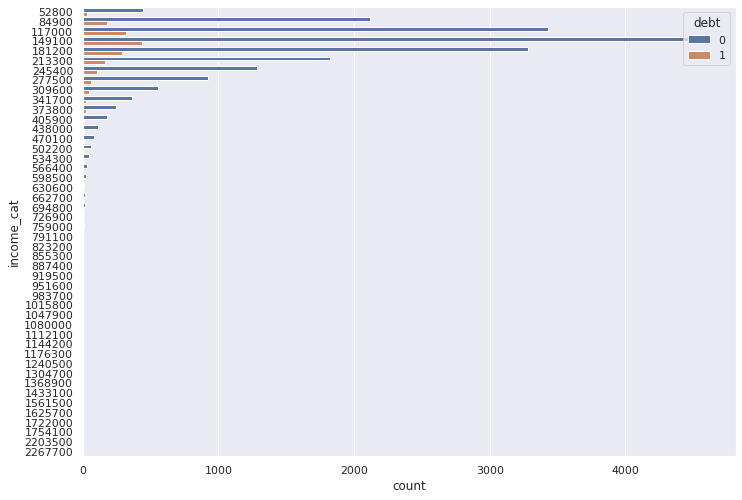

In [49]:
print(data.groupby('debt').agg({'total_income': ['min','mean','max']})) #простейший статистический анализ

#ВИЗУАЛИЗАЦИЯ
#создание списка с категориями - интервалами значений столбца data['total_income']
income_cat = [] #объявление этого списка
counter = round(data['total_income'].min() / 100)*100 #начальное значение счётчика - минимальное значение в колонке
cat_num = 70
for i in range(cat_num+1): #запускаем цикл с любым определённым нами числом категорий + 1 
    income_cat.append(counter) #добавляем в список значение в счётчике
    counter += round(((data['total_income'].max() - data['total_income'].min()) / cat_num) / 100)*100 #делим все значения на определённое количество интервалов и прибавляем этот интервал каждый раз к счётчику
#функция
def income_categories (row_value):
    for k in range(len(income_cat)): #цикл по выделенным категориям
        if round(row_value) > income_cat[k] and round(row_value) <= income_cat[k+1]: #сравнение значения колонки data['total_income'] со значениями категорий 
            return str(income_cat[k+1])

data['income_cat'] = data['total_income'].apply(income_categories)

df_plot = data[['total_income', 'income_cat', 'debt']]

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(y = 'income_cat', hue = 'debt', data = df_plot.sort_values(by = 'total_income'))

**Вывод**

Зависимость между уровнем дохода и возвратом кредита в срок имеется - чем выше доход, тем больше возвратов кредита в срок. Это абсолютно логично - человек с достатком удовлетворяет свои базовые поребности и имеет возможность делать дополнительные траты.

- Как разные цели кредита влияют на его возврат в срок?

In [50]:
#Способ 1: вывод с помощью сводной таблицы

data_pivot = data.pivot_table(index = 'debt', columns = 'purpose_lemmatized', values = 'total_income', aggfunc = 'count').apply(lambda x:100 * x / float(x.sum())).round(2)

print(data_pivot)

purpose_lemmatized  автомобиль  жилье  образование  свадьба
debt                                                       
0                        90.68  92.78        90.76    92.12
1                         9.32   7.22         9.24     7.88


In [51]:
#Способ 2: вывод с помощью цикла

i=0
borrowers = []
debtors = []
purpose = data['purpose_lemmatized'].unique()

for i in purpose:
    debtors.append(round(data[(data['purpose_lemmatized'] == i) & (data['debt'] == 1)]['debt'].count() / data[(data['purpose_lemmatized'] == i)]['debt'].count() * 100, 2))
    borrowers.append(round(data[(data['purpose_lemmatized'] == i) & (data['debt'] == 0)]['debt'].count() / data[(data['purpose_lemmatized'] == i)]['debt'].count() * 100, 2))

print(purpose)
print(debtors)
print(borrowers)

['жилье' 'автомобиль' 'образование' 'свадьба']
[7.22, 9.32, 9.24, 7.88]
[92.78, 90.68, 90.76, 92.12]


**Вывод**

Наибольший процент должников наблюдается в категории целей кредита "автомобиль", наименьший - в категории "жильё" (даже если объединять категории "недвижимость" и "жилье"). Это можно интерпретировать так - автомобиль не является предметом первой необходимости и если на нём не зарабатывают, то кредит является серьёзным обременением. Кредит на образование сложен тем, что нет гарантии трудоустройства, которое сможет обеспечить его погашение. Кредиты на свадьбы могут значительно проще гаситься сразу после свадьбы - многие гости дарят подарки деньгами. Ставки по ипотеке ниже кредитов, что также может объяснять наблюдения. Также срок использования автомобиля меньше срока использования жилья, автомобиль дешевеет и изнашивается со временем, а жильё дорожает.

# Общий вывод

Начальные данные состояли из 21525 строк, после обработки их осталось 21424. Выборка является достаточной для проведения исследования.

Обработка данных состояла в заполнении пропусков, корректировке неверных значений, обработке дубликатов, категоризации и лемматизации.

Выявлены следующие зависимости:
* с возрастанием количества детей от 0 до 4 возрастает количество должников
* с возрастанием дохода уменьшается количество должников
* цели кредита влияют на своевременный возврат кредита: наибольшее количество должников берут кредит на автомобиль, далее - на образование, на свадьбу и наименьшее количество должников берут кредит на жильё.